# Problem Statement:
    
- a Machine Learning model that classifies a given line as belonging to one of the 12 novels already labelled.

# 1- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
# deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical

In [5]:
! pip install version_information
%reload_ext version_information
%version_information pandas,numpy, keras, seaborn, matplotlib, sklearn

  Created wheel for version-information: filename=version_information-1.0.3-cp36-none-any.whl size=3881 sha256=1598355a79a0077d6dc213f21336de5684860d37b051f64a128bc7d4e4d9a987
  Stored in directory: /root/.cache/pip/wheels/1f/4c/b3/1976ac11dbd802723b564de1acaa453a72c36c95827e576321
Successfully built version-information


Software versions
Python 3.6.9 64bit [GCC 8.4.0]
IPython 5.5.0
OS Linux 4.19.112+ x86_64 with Ubuntu 18.04 bionic
pandas 1.0.5
numpy 1.18.5
keras 2.4.3
seaborn 0.10.1
matplotlib 3.2.2
sklearn 0.22.2.post1
Fri Sep 04 18:34:58 2020 UTC

# 2-Loading Data

In [6]:
data_xtrain=pd.read_csv('xtrain_obfuscated.txt', header = None,sep=" " )
data_xtrain.columns = ["text"]
data_xtrain.shape

(32513, 1)

In [7]:
data_xtrain.head()

,text
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...


In [8]:
data_xtest=pd.read_csv('xtest_obfuscated.txt', header = None,sep=" " )
data_xtest.columns = ["text"]
data_xtest.shape

(3000, 1)

In [9]:
data_xtest.head()

,text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [10]:
data_ytrain=pd.read_csv('ytrain.txt', header = None,sep=" " )
data_ytrain.columns = ["label"]
data_ytrain.shape

(32513, 1)

In [11]:
data_ytrain.head()

,label
0,7
1,3
2,8
3,3
4,4


In [12]:
data_ytrain.label.value_counts()

7     5097
6     4226
3     4023
8     3634
1     3459
10    3052
4     2337
5     2283
2     1471
11    1408
9      980
0      543
Name: label, dtype: int64

In [13]:
data_ytrain.label.value_counts(normalize=True)

7     0.156768
6     0.129979
3     0.123735
8     0.111771
1     0.106388
10    0.093870
4     0.071879
5     0.070218
2     0.045243
11    0.043306
9     0.030142
0     0.016701
Name: label, dtype: float64

# 3-Vectorize

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [15]:
x_train=data_xtrain.text
x_test=data_xtest.text

In [16]:
# using trigram and char as unit for analysis
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), analyzer='char')

In [17]:
#full_tfidf = tfidf_vec.fit_transform(train_data_x + test_data_x)
train_tfidf = tfidf_vec.fit_transform(x_train).toarray()
test_tfidf = tfidf_vec.transform(x_test).toarray()

In [18]:
print(train_tfidf.shape)
print(test_tfidf.shape)

(32513, 3398)
(3000, 3398)


In [19]:
labels = data_ytrain.label.astype(str)

In [20]:
pd.DataFrame(train_tfidf).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397
0,0.126480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.026665,0.0,0.0,0.026712,0.008209,0.0,0.008231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.095712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014032,0.0,0.0,0.020304,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.029217,0.0,0.0,0.0,0.029383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.026401,0.0,0.026472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.029377,0.0,0.0,0.029586,0.0,0.0,0.012498,0.0,0.0,0.0,0.012569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.015058,0.0,0.015098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025260,0.0,0.0,0.036550,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.038593,0.0,0.0,0.038662,0.015842,0.0,0.015884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.081580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013290,0.0,0.0,0.013314,0.024549,0.0,0.024614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4-ML models

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
   
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train_tfidf, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [22]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.629863
1,RandomForestClassifier,1,0.618638
2,RandomForestClassifier,2,0.624327
3,RandomForestClassifier,3,0.623193
4,RandomForestClassifier,4,0.620886
5,LinearSVC,0,0.764570
6,LinearSVC,1,0.749808
7,LinearSVC,2,0.752883
8,LinearSVC,3,0.754229
9,LinearSVC,4,0.748231


In [23]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.753944
LogisticRegression        0.661489
MultinomialNB             0.424446
RandomForestClassifier    0.623381
Name: accuracy, dtype: float64

# 5-Evaluate model

SVC is best performing model so we shall use it

In [24]:
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(train_tfidf, labels, x_train.index, test_size=0.20, random_state=0)

In [25]:
clf = LinearSVC()
clf.fit(X_train, y_train)
predictions = clf._predict_proba_lr(X_val)

In [26]:
print("Probability Distribution for 1st sample:",predictions[0])

Probability Distribution for 1st sample: [0.07345059 0.10450479 0.11500868 0.1176853  0.06947199 0.0919526
 0.05873454 0.08282792 0.06395337 0.06717727 0.07860529 0.07662764]


In [27]:
print("logloss: %0.3f " % metrics.log_loss(np.asarray(y_val), predictions))


logloss: 1.803 


In [28]:
# predict class type
y_pred = clf.predict(X_val)
y_pred[:5]

array(['11', '7', '1', '3', '5'], dtype=object)

In [29]:
# prediction values for class type
accuracy_value_class=predictions.max(axis=1)
accuracy_value_class[:5]

array([0.1176853 , 0.17435677, 0.160474  , 0.1642157 , 0.27929978])

In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.7573427648777488


In [31]:
#Function for category id
data_ytrain['category_id'] = data_ytrain['label'].factorize()[0]
category_id_df = data_ytrain[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

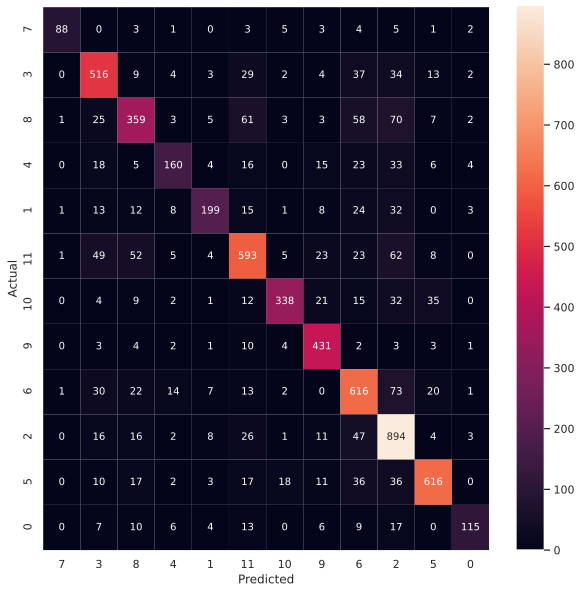

In [32]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       115
           1       0.75      0.79      0.77       653
          10       0.69      0.60      0.64       597
          11       0.77      0.56      0.65       284
           2       0.83      0.63      0.72       316
           3       0.73      0.72      0.73       825
           4       0.89      0.72      0.80       469
           5       0.80      0.93      0.86       464
           6       0.69      0.77      0.73       799
           7       0.69      0.87      0.77      1028
           8       0.86      0.80      0.83       766
           9       0.86      0.61      0.72       187

    accuracy                           0.76      6503
   macro avg       0.79      0.73      0.76      6503
weighted avg       0.76      0.76      0.76      6503



We calculated 

- Log_loss (lower is better)
- Accuracy 
- Precision
- Recall
- f1

# ML Model for Prediction on test dataset

In [34]:
data_xtest.head()

,text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [35]:
labels.head()

0    7
1    3
2    8
3    3
4    4
Name: label, dtype: object

In [36]:
clf.fit(train_tfidf, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [37]:
y_pred = clf.predict(test_tfidf)
y_pred[:5]

array(['6', '11', '8', '8', '8'], dtype=object)

In [38]:
print(y_pred.shape)

(3000,)


In [39]:
# probability distribution acc. all 12 classes
prediction_df=pd.DataFrame(clf._predict_proba_lr(test_tfidf), columns=clf.classes_)
prediction_df[:5]

,0,1,10,11,2,3,4,5,6,7,8,9
0,0.075169,0.067180,0.067714,0.057420,0.057642,0.082979,0.065305,0.040997,0.234623,0.094901,0.062265,0.093804
1,0.029431,0.088391,0.081246,0.206996,0.075486,0.104373,0.060481,0.085047,0.098058,0.029675,0.062625,0.078192
2,0.053382,0.062175,0.105786,0.086154,0.111127,0.109070,0.107947,0.029048,0.049669,0.095432,0.128962,0.061247
3,0.031155,0.125015,0.021441,0.042419,0.059697,0.036248,0.125396,0.049418,0.142872,0.023649,0.271309,0.071381
4,0.057864,0.063223,0.097905,0.058901,0.103011,0.091667,0.130830,0.042778,0.081880,0.054069,0.157652,0.060220


In [40]:
accuracy_value_class=prediction_df.max(axis=1)

In [41]:
df_submit=data_xtest.copy()
df_submit["predicted_class"]=y_pred
df_submit["probability"]=accuracy_value_class
df_submit.head()

,text,predicted_class,probability
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...,6,0.234623
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...,11,0.206996
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...,8,0.128962
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...,8,0.271309
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...,8,0.157652


In [42]:
df_submit.shape

(3000, 3)

# 6-Apply Sequence model using Recurrent NN

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

In [44]:
y=data_ytrain.label
X=data_xtrain.text
print(X.shape)
print(y.shape)

(32513,)
(32513,)


In [58]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 200
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,char_level=True)
tokenizer.fit_on_texts(X.values)

In [59]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26 unique tokens.


In [60]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X.values)

In [61]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451
0,15,11,8,7,11,3,1,6,1,2,13,17,1,6,11,3,6,16,3,4,5,18,1,2,13,4,12,16,10,3,6,5,8,7,1,6,23,9,8,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,7,3,12,9,7,10,3,13,4,8,7,6,5,1,2,15,11,9,7,15,12,8,7,3,4,6,5,6,5,12,16,11,3,1,2,13,4,12,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,9,19,20,10,3,15,12,1,2,4,9,6,5,10,3,1,6,1,2,8,7,8,4,1,2,1,6,15,24,4,9,5,14,11,3,13,4,1,2,...,8.0,7.0,11.0,3.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,11,15,12,6,5,5,14,12,16,6,16,1,2,8,7,1,6,5,14,6,5,5,14,17,18,8,7,13,4,1,2,5,14,1,2,15,11,8,4,...,1.0,6.0,1.0,2.0,15.0,12.0,4.0,9.0,12.0,16.0,10.0,3.0,13.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,20,5,14,13,4,1,2,8,7,11,3,13,4,1,2,13,17,8,7,9,7,8,4,5,14,1,6,1,2,13,4,9,25,6,5,8,7,11,3,...,4.0,9.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [63]:
print('Shape of data tensor:', X_pd_sq.shape)

Shape of data tensor: (32513, 100)


In [64]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,17,18,8,7,8,7,15,12,1,2,8,7,6,16,12,16,10,3,6,16,1,2,10,3,1,6,1,2,13,4,5,14,1,2,8,7,21,10,6,5,...,11,3,1,6,3,4,19,20,1,2,13,4,15,12,5,14,8,7,11,3,6,5,8,7,6,16,6,16,10,3,9,7,1,2,8,7,11,3,1,6
1,8,7,6,5,1,2,4,9,5,14,3,4,21,10,13,4,10,3,25,5,1,2,22,5,10,3,1,2,6,5,12,16,8,7,1,6,5,14,5,18,...,6,5,17,18,1,2,15,12,8,7,1,6,5,14,6,5,8,4,8,7,9,7,8,7,21,10,1,2,8,7,11,3,1,6,1,2,10,3,1,6
2,9,7,17,18,13,4,1,2,9,7,9,7,15,24,9,17,1,2,6,5,10,3,1,2,13,17,8,7,5,18,1,2,5,18,10,3,6,5,22,5,...,15,24,1,2,1,2,16,11,17,18,13,4,5,14,6,5,6,16,1,2,13,4,15,24,9,7,6,5,3,4,6,16,1,2,8,7,11,3,1,6
3,6,5,5,14,8,7,1,2,15,11,5,18,1,2,8,7,15,12,3,4,13,4,4,9,3,4,1,2,6,16,4,9,3,4,11,3,1,6,8,7,...,10,3,1,6,1,2,15,12,8,7,5,18,8,7,8,7,13,4,1,2,1,6,5,14,11,3,1,6,1,2,15,12,4,9,12,16,10,3,13,4
4,1,23,3,4,9,7,1,2,1,6,5,14,8,7,8,4,1,2,5,14,1,2,11,3,1,6,3,4,19,20,1,2,15,12,4,9,10,3,21,10,...,8,7,6,5,12,16,13,4,5,14,8,7,5,18,1,2,11,3,21,10,3,4,11,3,19,20,1,2,13,17,1,6,3,4,1,2,4,9,3,4


In [65]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_pd_sq,y,random_state=42)

In [66]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(24384, 100)
(8129, 100)
(24384,)
(8129,)


In [87]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_val_ohe=one_hot_encode_object_array(y_val)

In [69]:
y_train[:5]

15170    10
26733     8
4122      7
7585      3
28354     2
Name: label, dtype: int64

In [70]:
y_train_ohe[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [71]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

[7, 6, 3, 8, 1, 10, 4, 5, 2, 11, 9, 0]

In [72]:
len(unique_y_labels)

12

# Defining LSTM

In [77]:
input_length=X_pd_sq.shape[1]
uniq_y_label=len(unique_y_labels)
batch_size = 64
epochs = 15

In [74]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pd_sq.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(uniq_y_label, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          20000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 101,612
Trainable params: 101,612
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
# for imbalanced classes
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [84]:
# early stopping
from keras.callbacks import EarlyStopping
history=model.fit(X_train,y_train_ohe,validation_data=(X_val,y_val_ohe),
                          epochs=epochs,batch_size=batch_size,
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3, 
                                                   min_delta=0.0001)])

Epoch 1/15
381/381 [==============================] - 51s 133ms/step - loss: 2.0127 - accuracy: 0.2840 - val_loss: 1.9921 - val_accuracy: 0.2833
Epoch 2/15
381/381 [==============================] - 51s 133ms/step - loss: 1.9940 - accuracy: 0.2923 - val_loss: 1.9791 - val_accuracy: 0.2882
Epoch 3/15
381/381 [==============================] - 50s 132ms/step - loss: 1.9796 - accuracy: 0.2953 - val_loss: 1.9474 - val_accuracy: 0.2977
Epoch 4/15
381/381 [==============================] - 50s 132ms/step - loss: 1.9616 - accuracy: 0.3039 - val_loss: 1.9203 - val_accuracy: 0.3157
Epoch 5/15
381/381 [==============================] - 50s 132ms/step - loss: 1.9474 - accuracy: 0.3069 - val_loss: 1.9218 - val_accuracy: 0.3178
Epoch 6/15
381/381 [==============================] - 51s 134ms/step - loss: 1.9269 - accuracy: 0.3143 - val_loss: 1.8727 - val_accuracy: 0.3186
Epoch 7/15
381/381 [==============================] - 51s 133ms/step - loss: 1.8955 - accuracy: 0.3237 - val_loss: 1.8506 - val_ac

# Evaluate

In [85]:
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.3834
Training Loss: 1.7243


In [88]:
loss, accuracy = model.evaluate(X_val, y_val_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.3382
Testing Loss:  1.8498


In [89]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

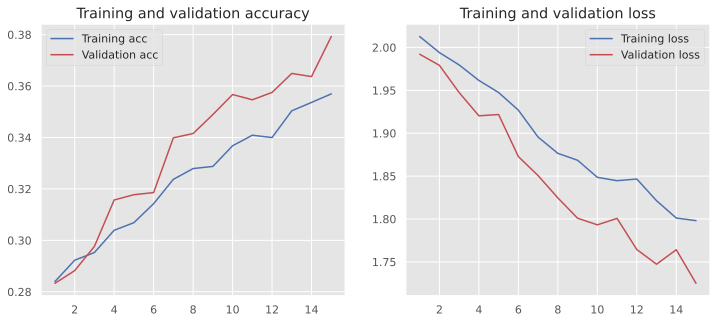

In [90]:
plot_history(history)

In [93]:
y_pred = model.predict(X_val)

In [94]:
## predict crisp classes for test set. Output will be 1-D
y_val_class = np.argmax(y_val_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [95]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_val_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.67      0.24      0.35       126
           1       0.33      0.38      0.35       848
           2       0.19      0.10      0.13       354
           3       0.39      0.36      0.37      1012
           4       0.60      0.28      0.38       592
           5       0.39      0.59      0.47       576
           6       0.31      0.43      0.36      1077
           7       0.25      0.50      0.33      1208
           8       0.64      0.34      0.45       906
           9       0.14      0.01      0.02       250
          10       0.33      0.09      0.14       807
          11       0.25      0.11      0.15       373

    accuracy                           0.34      8129
   macro avg       0.37      0.29      0.29      8129
weighted avg       0.37      0.34      0.32      8129



In [99]:
print(confusion_matrix(y_val_class,y_pred_class))

[[ 30   5   3   6  13  23   9  26   0   2   1   8]
 [  0 320  12 115   1  55 122 186  17   0   5  15]
 [  0  38  34  26   0  53  86  95   1   0  14   7]
 [  1 153  22 360   6  99  98 216   8   0  31  18]
 [  6   7   5  44 164  75  49 175  53   2   9   3]
 [  1  34   9  49  27 340  12  76   9   1   5  13]
 [  0 113  10  36   1  26 467 362  43   2   5  12]
 [  5  89  19 103   3  58 251 605  14   1  45  15]
 [  0  51   4  36  49  36 121 272 312   2  13  10]
 [  0  19  19  32   1  33  40  77   4   2  13  10]
 [  2  76  19 106   7  46 183 261  22   0  74  11]
 [  0  63  22  21   0  37  63 111   5   2   8  41]]


### weights at each step of neural network

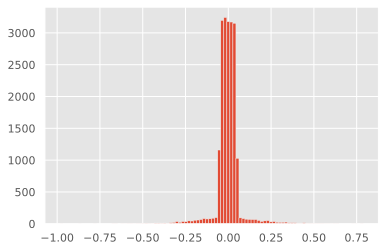

In [100]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [101]:
model.weights

[<tf.Variable 'embedding/embeddings:0' shape=(200, 100) dtype=float32, numpy=
 array([[ 2.0615067e-02,  4.4893026e-03, -7.7363141e-03, ...,
          2.8812651e-02, -3.9001785e-02,  5.6914575e-03],
        [ 3.7891049e-02, -5.3781852e-02,  2.5562670e-02, ...,
         -1.2945469e-01, -2.9472288e-02, -6.8472438e-02],
        [ 1.2542424e-01,  2.3268254e-01, -2.4428664e-02, ...,
          1.8619733e-02, -1.5174010e-01,  3.5381164e-02],
        ...,
        [-4.4716932e-02, -2.2915293e-02, -3.3069767e-02, ...,
         -3.9396174e-03, -3.9796602e-02,  3.8658824e-02],
        [-1.6069412e-04, -3.8645435e-02,  1.4867190e-02, ...,
         -4.1827522e-02,  1.6911253e-03, -2.6437784e-02],
        [ 2.0659003e-02, -4.5492448e-02, -5.0474033e-03, ...,
          2.7000133e-02,  2.9116776e-02,  8.0107078e-03]], dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell/kernel:0' shape=(100, 400) dtype=float32, numpy=
 array([[ 0.02363151,  0.14521486,  0.2710745 , ...,  0.04284266,
         -0.00683515,  0.0